# Exploratory Analisys

## Context

This notebook aims to explore the linear structure of average  temperature over time as a preparatory step for building a hybrid forecast model. By analyzing trend, seasonal patterns and linear temporal dependence we seek to understand how much of the temperature variability can be explained by linear components. The non-linear structure will be analize in an second notebook.

**Data Source**
The data used in this notebook was extracted from the notebook *sanity-check.ipynb*

- **Data:** 16/08/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistic
import scipy
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[0].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

## Data

In [4]:
weather_df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_sanitized.parquet'))
weather_df = weather_df.loc[weather_df['time'].dt.year <= 2021].copy()
display(weather_df.tail())
weather_df.info()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal
2324,2021-12-27,278.2,6.9,0.0,4.8,1006.7,7.8,West
2325,2021-12-28,275.4,6.9,25.0,3.4,1008.1,3.2,East
2326,2021-12-29,275.6,0.5,0.0,3.9,1012.7,3.9,Northwest
2327,2021-12-30,275.8,0.0,0.0,2.7,1012.2,3.2,Southeast
2328,2021-12-31,277.9,0.0,0.0,3.4,1007.3,6.7,Northeast


<class 'pandas.core.frame.DataFrame'>
Index: 2329 entries, 0 to 2328
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       2329 non-null   datetime64[ns]
 1   tavg       2329 non-null   float64       
 2   prcp       2329 non-null   float64       
 3   snow       2329 non-null   float64       
 4   wspd       2329 non-null   float64       
 5   pres       2329 non-null   float64       
 6   tamp       2329 non-null   float64       
 7   wcardinal  2315 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(6)
memory usage: 148.2 KB


# Heteroscedastic
The first step is to address the seasonal heteroscedasticity in the data. To this end, we apply two classic variance-stabilizing transformations: logarithmic and Box–Cox, both designed to smooth the series and facilitate modeling. After transformation, we need to determine whether the transformed target or the original data is easier to forecast. To do this, we decompose the series into its seasonal and trend components before making a decision.

## Log Transformation

The logarithmic transformation is most effective when variability increases proportionally with the magnitude of the target. In our case, the relationship is inverse: variability decreases as the values increase. To account for this, we apply the transformation $log⁡(1/x)$, where $x$ represents the feature value.

In [5]:
def log_transf(serie: pd.Series):
    return serie.apply(lambda x: np.log(1/x))
def inv_log_transf(array: np.array):
    return 1/np.exp(array)

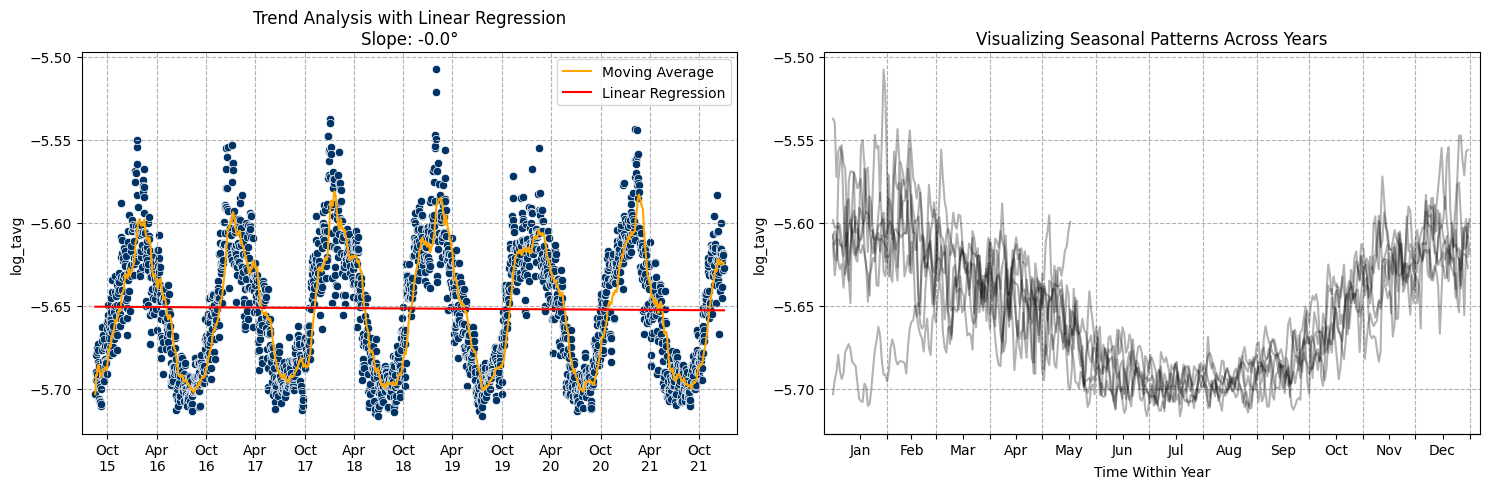

In [6]:
weather_df['log_tavg'] = log_transf(weather_df['tavg'])
ts_quick_insights(weather_df['log_tavg'], weather_df['time'])   

## Box-Cox Transformation
For the Box–Cox transformation, the same principle as for the logarithmic transformation applies. Therefore, we apply the Box–Cox transformation to $1/x$, where $x$ is the feature value. Unlike the logarithm, the Box–Cox transformation can automatically select an optimal power parameter $λ$ to stabilize variance, providing a more flexible approach to variance stabilization.

In [7]:
def box_transf(serie: pd.Series):
    return scipy.stats.boxcox(1/serie)
def inv_box_transf(serie: np.array, lmbda: float):
    return 1/scipy.special.inv_boxcox(serie, lmbda)

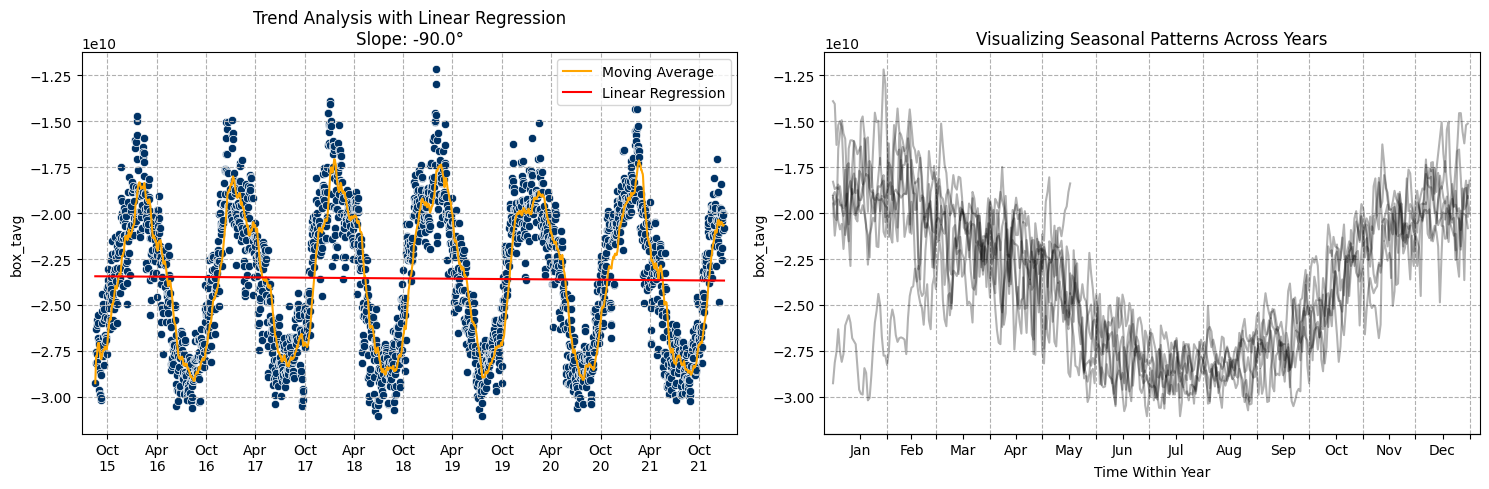

In [8]:
weather_df['box_tavg'], lmbda = box_transf(weather_df['tavg'])
ts_quick_insights(weather_df['box_tavg'], weather_df['time'])   

# Trend Decomposition
As observed in the plots, the slope of both the transformed and original data is approximately zero (or 90 degrees). Based on this, we can conclude that there is no discernible trend in any of the targets.

# Seasonal Decomposition
However, the data exhibit a clear annual seasonal pattern. Because this pattern is pronounced and we are addressing seasonal heteroscedasticity, we apply harmonic regression to model and remove the seasonal component. Additionally, to account for the heteroscedasticity, we use a quantile regression with $q=0.5$, as our main objective is to predict the temperature while minimizing the width of the prediction interval.

In [9]:
n = len(weather_df)
t = np.arange(n)

omega1 = (2 * np.pi / 365.25)
omega2 = 2 * (2 * np.pi / 365.25)
omega3 = 3 * (2 * np.pi / 365.25)

We include additional harmonic terms to ensure that all relevant seasonal patterns are captured, selecting those terms whose p-values indicate they are statistically significant for prediction ($< 0.05$).

In [10]:
residuals = pd.DataFrame() # Object to store the residuals

## Seasonal tavg
Despite the transformation, it is still premature to disregard the original data. Therefore, we will analyze it alongside the other variables on an equal footing.

In [11]:
y = weather_df['tavg'].copy()
X = np.column_stack([
    np.ones(n), # Intercept           
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

model = QuantReg(y, X)
res = model.fit(q=0.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   tavg   Pseudo R-squared:               0.6164
Model:                       QuantReg   Bandwidth:                       1.512
Method:                 Least Squares   Sparsity:                        10.18
Date:                Sun, 17 Aug 2025   No. Observations:                 2329
Time:                        03:18:14   Df Residuals:                     2322
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        285.0106      0.106   2696.436      0.000     284.803     285.218
x1            -5.2159      0.149    -35.095      0.000      -5.507      -4.924
x2            12.3674      0.150     82.259      0.000      12.073      12.662
x3             0.0184      0.149      0.123      0.902      -0.275       0.312
x4             0.5609      0.149      3.753      0.000       0.268       0.854
x5             0.2158      0.150      1.442      0.150      -0.078       0.509
x6            -0.2446      0.149     -1.642      0.101      -0.537       0.048
==============================================================================
"""

Using a 5% significance threshold, we determined that components 3, 5, and 6 are not statistically significant and will therefore be excluded from the prediction.

In [12]:
y = weather_df['tavg'].copy()
X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t)
])

model = QuantReg(y, X)
res = model.fit(q=0.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   tavg   Pseudo R-squared:               0.6157
Model:                       QuantReg   Bandwidth:                       1.513
Method:                 Least Squares   Sparsity:                        10.05
Date:                Sun, 17 Aug 2025   No. Observations:                 2329
Time:                        03:18:14   Df Residuals:                     2325
                                        Df Model:                            3
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        285.0136      0.104   2731.715      0.000     284.809     285.218
x1            -5.1765      0.147    -35.283      0.000      -5.464      -4.889
x2            12.4230      0.148     83.804      0.000      12.132      12.714
x3             0.4747      0.147      3.221      0.001       0.186       0.764
==============================================================================
"""

Let’s examine the residuals to verify whether the regression has fitted the data as expected.

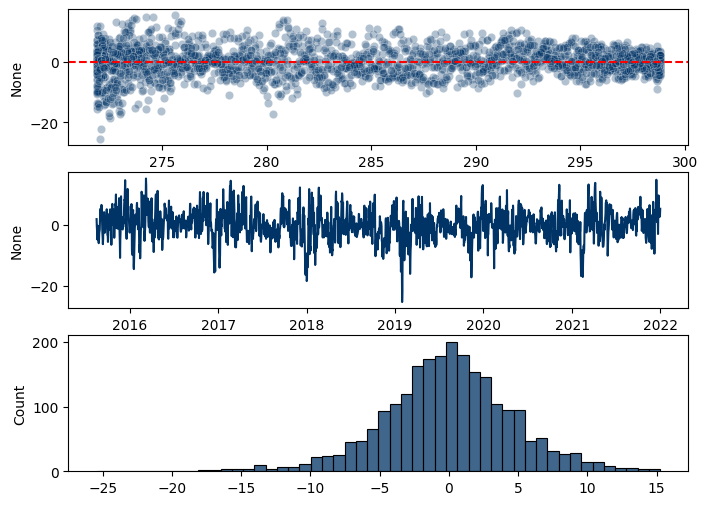

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=res.predict(X), y=res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=res.resid, ax=ax[1])

sns.histplot(res.resid, ax=ax[2])

plt.show()

As shown in the second plot, seasonal heteroscedasticity is still present in the residuals of the original data, as expected.

In [14]:
residuals['resid'] = res.resid

## Seasonal Log
Now, for the logarithmic transformation, we will examine it in the same way as the original variable.

In [15]:
log_y = weather_df['log_tavg'].copy()
log_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

log_model = QuantReg(log_y, log_X)
log_res = log_model.fit(q=0.5)
log_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               log_tavg   Pseudo R-squared:               0.6136
Model:                       QuantReg   Bandwidth:                    0.005293
Method:                 Least Squares   Sparsity:                      0.03560
Date:                Sun, 17 Aug 2025   No. Observations:                 2329
Time:                        03:18:14   Df Residuals:                     2322
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6520      0.000  -1.53e+04      0.000      -5.653      -5.651
x1             0.0184      0.001     35.394      0.000       0.017       0.019
x2            -0.0435      0.001    -82.644      0.000      -0.044      -0.042
x3            -0.0005      0.001     -0.981      0.327      -0.002       0.001
x4            -0.0016      0.001     -3.103      0.002      -0.003      -0.001
x5            -0.0008      0.001     -1.548      0.122      -0.002       0.000
x6             0.0008      0.001      1.529      0.126      -0.000       0.002
==============================================================================
"""

As shown in the summary above, only the constant and components 1, 2, and 4 are statistically useful for our regression.

In [16]:
log_y = weather_df['log_tavg'].copy()
log_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t)
])

log_model = QuantReg(log_y, log_X)
log_res = log_model.fit(q=0.5)
log_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               log_tavg   Pseudo R-squared:               0.6126
Model:                       QuantReg   Bandwidth:                    0.005285
Method:                 Least Squares   Sparsity:                      0.03497
Date:                Sun, 17 Aug 2025   No. Observations:                 2329
Time:                        03:18:15   Df Residuals:                     2325
                                        Df Model:                            3
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6520      0.000  -1.56e+04      0.000      -5.653      -5.651
x1             0.0180      0.001     35.348      0.000       0.017       0.019
x2            -0.0435      0.001    -84.242      0.000      -0.044      -0.042
x3            -0.0013      0.001     -2.439      0.015      -0.002      -0.000
==============================================================================
"""

As we did previously, let’s analyze the residuals.

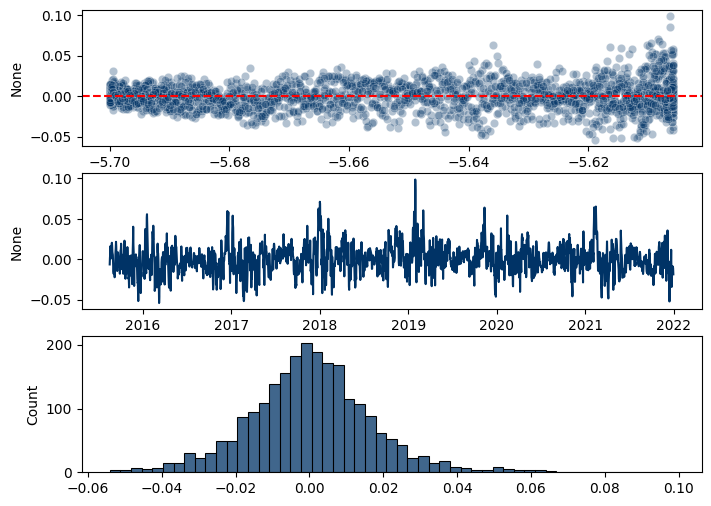

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=log_res.predict(log_X), y=log_res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=log_res.resid, ax=ax[1])

sns.histplot(log_res.resid, ax=ax[2])

plt.show()

As shown above, despite our efforts, the transformation was unable to eliminate the heteroscedasticity, which continues to be present in the residuals.

In [18]:
log_predict = inv_log_transf(log_res.predict(log_X))
residuals['log_resid'] = weather_df['tavg'] - log_predict

## Seasonal Box-Cox
The Box–Cox transformation has already been applied, and we will now run the harmonic regression on this transformed data, including all harmonic components.

In [19]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

box_model = QuantReg(box_y, box_X)
box_res = box_model.fit(q=0.5)
box_res.summary()

/home/pedro.moura/Pessoal/WeatherForecast/venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               box_tavg   Pseudo R-squared:               0.6243
Model:                       QuantReg   Bandwidth:                   5.661e+08
Method:                 Least Squares   Sparsity:                    3.750e+09
Date:                Sun, 17 Aug 2025   No. Observations:                 2329
Time:                        03:18:15   Df Residuals:                     2322
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.353e+10   3.89e+07   -604.151      0.000   -2.36e+10   -2.34e+10
x1          1.918e+09   5.48e+07     35.038      0.000    1.81e+09    2.03e+09
x2         -4.573e+09   5.54e+07    -82.556      0.000   -4.68e+09   -4.46e+09
x3          1.319e+08   5.51e+07      2.394      0.017    2.39e+07     2.4e+08
x4         -3.393e+08   5.51e+07     -6.161      0.000   -4.47e+08   -2.31e+08
x5         -7.035e+07   5.51e+07     -1.276      0.202   -1.78e+08    3.78e+07
x6          6.662e+07   5.49e+07      1.214      0.225    -4.1e+07    1.74e+08
==============================================================================
"""

Unlike the regressions above, the statistically significant components here are 1, 2, 3, and 4. Component 3, which was not significant in the previous regressions, is significant in this case — a positive development, as it may indicate additional information that can contribute to improved predictions.

In [20]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t)
])

box_model = QuantReg(box_y, box_X)
box_res = box_model.fit(q=0.5, method='simplex', max_iter=100000)
box_res.summary()

/home/pedro.moura/Pessoal/WeatherForecast/venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (100000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               box_tavg   Pseudo R-squared:               0.6238
Model:                       QuantReg   Bandwidth:                   5.652e+08
Method:                 Least Squares   Sparsity:                    3.743e+09
Date:                Sun, 17 Aug 2025   No. Observations:                 2329
Time:                        03:18:33   Df Residuals:                     2324
                                        Df Model:                            4
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.353e+10   3.89e+07   -605.365      0.000   -2.36e+10   -2.35e+10
x1          1.911e+09   5.47e+07     34.959      0.000     1.8e+09    2.02e+09
x2         -4.583e+09   5.53e+07    -82.926      0.000   -4.69e+09   -4.47e+09
x3          1.136e+08   5.49e+07      2.069      0.039    5.93e+06    2.21e+08
x4         -3.332e+08   5.49e+07     -6.069      0.000   -4.41e+08   -2.26e+08
==============================================================================
"""

Despite increasing the maximum number of iterations and testing multiple optimization methods, none were able to properly converge the coefficients. Therefore, the Quantile Regression for the Box–Cox–transformed data was disregarded, and we will instead apply OLS regression, as it tends to be more stable.

## Seasonal OLS Box-Cox
Here, we follow the same approach as before: we test multiple harmonic terms and retain only those that are statistically significant.

In [21]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

box_model = sm.OLS(box_y, box_X)
box_res = box_model.fit()
box_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               box_tavg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1776.
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        03:18:33   Log-Likelihood:                -52745.
No. Observations:                2329   AIC:                         1.055e+05
Df Residuals:                    2322   BIC:                         1.055e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.356e+10   3.45e+07   -683.514      0.000   -2.36e+10   -2.35e+10
x1          1.996e+09   4.85e+07     41.187      0.000     1.9e+09    2.09e+09
x2         -4.632e+09    4.9e+07    -94.476      0.000   -4.73e+09   -4.54e+09
x3          8.454e+06   4.88e+07      0.173      0.862   -8.71e+07    1.04e+08
x4         -2.789e+08   4.87e+07     -5.723      0.000   -3.75e+08   -1.83e+08
x5         -3.395e+07   4.88e+07     -0.696      0.487    -1.3e+08    6.18e+07
x6          5.899e+07   4.86e+07      1.214      0.225   -3.63e+07    1.54e+08
==============================================================================
Omnibus:                       12.683   Durbin-Watson:                   0.557
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.696
Skew:                          -0.110   Prob(JB):                     0.000644
Kurtosis:                       3.321   Cond. No.                         1.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Unlike in the quantile regression, only harmonic terms 1, 2, and 4 were found to be relevant.

In [22]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t)
])

box_model = sm.OLS(box_y, box_X)
box_res = box_model.fit()
box_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               box_tavg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     3553.
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        03:18:33   Log-Likelihood:                -52746.
No. Observations:                2329   AIC:                         1.055e+05
Df Residuals:                    2325   BIC:                         1.055e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.356e+10   3.45e+07   -683.782      0.000   -2.36e+10   -2.35e+10
x1          1.997e+09   4.85e+07     41.212      0.000     1.9e+09    2.09e+09
x2         -4.634e+09    4.9e+07    -94.647      0.000   -4.73e+09   -4.54e+09
x3         -2.794e+08   4.87e+07     -5.740      0.000   -3.75e+08   -1.84e+08
==============================================================================
Omnibus:                       12.337   Durbin-Watson:                   0.557
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.851
Skew:                          -0.119   Prob(JB):                     0.000983
Kurtosis:                       3.294   Cond. No.                         1.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With the regression trained, we now examine the residuals and save the data for subsequent analysis.

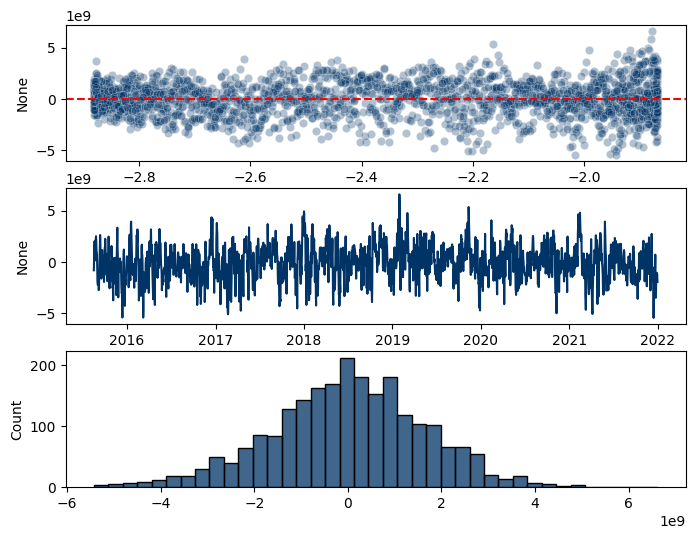

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=box_res.predict(box_X), y=box_res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=box_res.resid, ax=ax[1])

sns.histplot(box_res.resid, ax=ax[2])

plt.show()

Based on the residual plots, the Box–Cox transformation appears to handle heteroscedasticity better than the other transformations. However, this assessment is currently purely visual. To confirm, we will perform the Breusch–Pagan test to formally evaluate whether heteroscedasticity persists, using a 5% significance level to determine rejection of the null hypothesis.

- **Null hypothesis**: Residuals are homoscedastic.
- **Alternativa hypothesis**: Heteroscedasticity present.

In [24]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(box_res.resid, box_X)
f_pvalue

np.float64(8.494633362003943e-18)

From the test above, we reject the null hypothesis, indicating that heteroscedasticity is still present. However, visually the heteroscedasticity appears less pronounced than in the other variables. The other residuals exhibit more prominent seasonal peaks and troughs, highlighting stronger seasonal heteroscedasticity compared to the Box–Cox–transformed data

In [25]:
box_predict = inv_box_transf(box_res.predict(box_X), lmbda)
residuals['box_resid'] = weather_df['tavg'] - box_predict

# Residuals Analysis
Now, let us examine the residuals to determine which method best fits our objective. The primary metric will be the interquartile range (IQR), chosen for its direct relationship with the width of the prediction interval, which we aim to minimize.

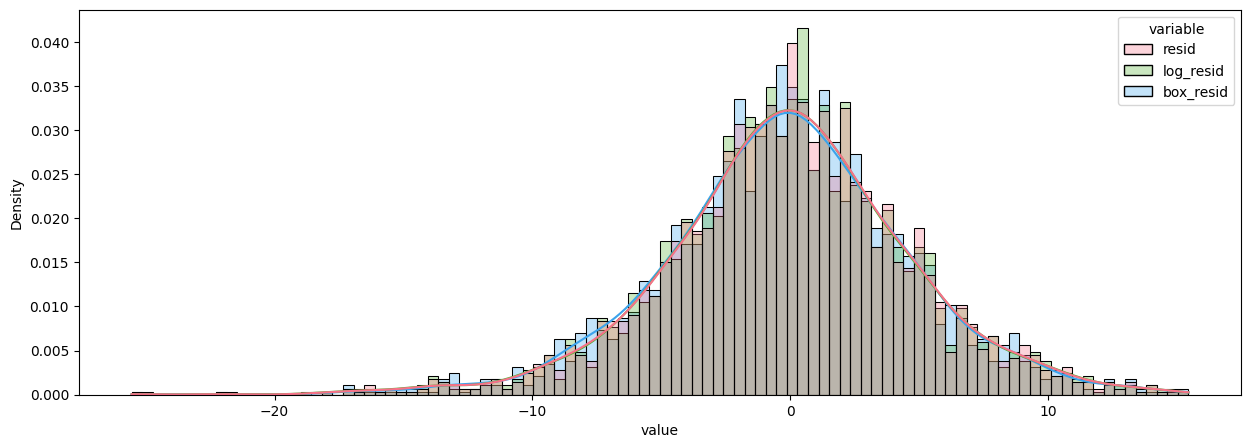

value                                                         \
            count      mean       std        min       25%           50%   
variable                                                                   
box_resid  2329.0 -0.139103  4.737744 -25.028014 -2.926904 -1.040501e-01   
log_resid  2329.0 -0.076275  4.762234 -25.541683 -2.747063 -1.917413e-05   
resid      2329.0 -0.062913  4.754509 -25.442619 -2.719050  4.673270e-07   

                                     IQR  
                75%        max            
variable                                  
box_resid  2.729750  15.439559  5.656654  
log_resid  2.737896  15.316577  5.484959  
resid      2.765950  15.266171  5.485000

In [26]:
df_resid = residuals.melt()

plt.figure(figsize=(15, 5))
sns.histplot(data=df_resid, x='value', hue='variable', stat='density', bins=100, kde=True, alpha=0.3)
plt.show()

desc_resid = df_resid.groupby('variable').describe()
desc_resid['IQR'] = desc_resid[('value',   '75%')] - desc_resid[('value',   '25%')]
desc_resid

Although the Box–Cox transformation appeared to handle heteroscedasticity most effectively, it performed worst in terms of prediction, exhibiting the highest IQR and largest average error. While the IQR of the residuals for the Box–Cox and logarithmic transformations are similar, other metrics — including the mean, standard deviation, and the range between maximum and minimum — suggest that the original data is better suited for the subsequent analysis.

In [27]:
weather_df['y_hat'] = res.predict(X)
weather_df['resid'] = res.resid
weather_df.head()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal,log_tavg,box_tavg,y_hat,resid
0,2015-08-17,299.8,3.8,0.0,3.5,1015.1,10.0,Southwest,-5.703116,-2.926462e+10,297.911269,1.888731
1,2015-08-18,297.2,22.9,0.0,3.9,1009.2,7.8,South,-5.694405,-2.814244e+10,297.820107,-0.620107
2,2015-08-19,295.8,0.0,0.0,6.6,1004.8,8.3,Southwest,-5.689684,-2.755221e+10,297.724733,-1.924733
3,2015-08-20,292.8,0.0,0.0,6.6,1010.2,8.3,West,-5.679490,-2.631984e+10,297.625178,-4.825178
4,2015-08-21,295.8,0.0,0.0,3.9,1017.5,13.2,South,-5.689684,-2.755221e+10,297.521471,-1.721471


# Conclusion

In [28]:
DATA_PATH_WRANGLE.mkdir(parents=True, exist_ok=True)
weather_df.to_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_linear_resids.parquet'))